In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from xgboost import XGBClassifier
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor
#import linear regression
from sklearn.linear_model import LinearRegression
# import tqdm
from tqdm import tqdm
import tqdm
#import r2_score
from sklearn.metrics import r2_score
#import confusion matrix
from sklearn.metrics import confusion_matrix
# import roc auc score
from sklearn.metrics import roc_auc_score
from food_crisis_functions import *
import json
with open("forecasting_hyperparameters.json", "r") as file:
    best_params_xgb_regressor= json.load(file)
    
with open("forecasting_hyperparameters_p3.json", "r") as file:
    best_params_xgb_regressor_for_p3= json.load(file)


In [2]:
df = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\forecasting_subset_IPCCH_v1210.csv')
# add dummys for area_id and month year
#df = pd.concat([df, pd.get_dummies(df['area_id'], prefix='area_id')], axis=1)
#df = pd.concat([df, pd.get_dummies(df['date'], prefix='month_year')], axis=1)
# drop lat and lon
#df = df.drop(['lat', 'lon'], axis=1)
###drop fews_ipc_ha
#df = df.drop(['fews_ipc_ha'], axis=1)
# random split train and test

# prepare date from year and month
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
# check for inf and replace with na
df = df.replace([np.inf, -np.inf], np.nan)

# replace df['overall_phase], 0 as 1, >5 as 5
df['overall_phase'] = df['overall_phase'].apply(lambda x: 1 if x < 1 else (5 if x > 5 else x))

df_origin = df.copy()
y_pred_test = pd.DataFrame()
model_stats = pd.DataFrame()
#select phase1_percent is not na
df = df_origin[df_origin['phase1_percent'].notna()]

# Sort by region and date
df = df.sort_values(by=['area_id', 'date'])
#for each region, set last observation to be test set
# create a series of new outcome, phase2_worse=phase2_percent+phase3_percent+phase4_percent+phase5_percent, phase3_worse=phase3_percent+phase4_percent+phase5_percent, phase4_worse=phase4_percent+phase5_percent, phase5_worse=phase5_percent
df['phase2_worse'] = df['phase2_percent'] + df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase3_worse'] = df['phase3_percent'] + df['phase4_percent'] + df['phase5_percent']
df['phase4_worse'] = df['phase4_percent'] + df['phase5_percent']
df['phase5_worse'] = df['phase5_percent']
#drop phase2_percent, phase3_percent, phase4_percent, phase5_percent, phase1_percent
df = df.drop(['phase2_percent', 'phase3_percent', 'phase4_percent', 'phase5_percent', 'phase1_percent'], axis=1)

In [3]:
# for area_id, if >100000 then first -100000 then +5000
df['area_id'] = df['area_id'].apply(lambda x: x - 100000 + 5000 if x >= 100000 else x)

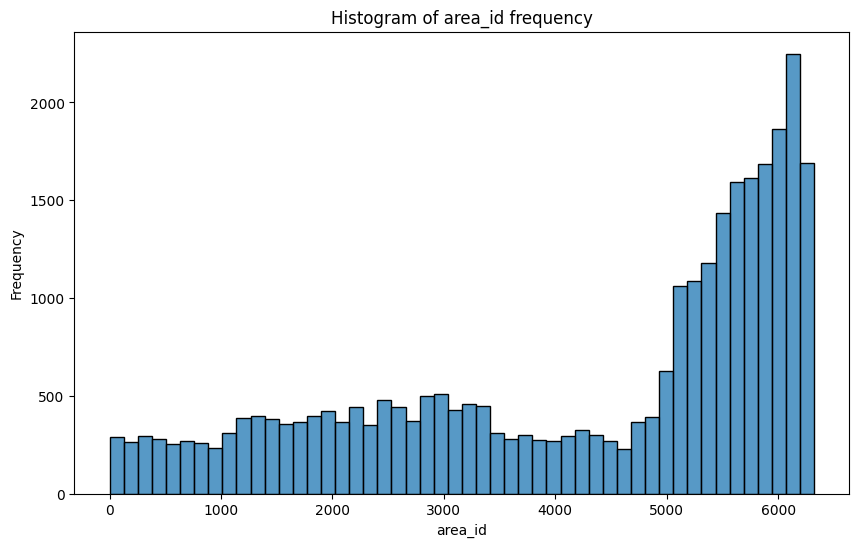

In [4]:
#plot histogram of area_id frequency
plt.figure(figsize=(10,6))
sns.histplot(df['area_id'], bins=50)
plt.title('Histogram of area_id frequency')
plt.xlabel('area_id')
plt.ylabel('Frequency')
plt.show()


In [5]:
df = df[['area_id','date','phase2_worse','phase3_worse','phase4_worse','phase5_worse']]

In [6]:
# generate overall_phase_pred, group by area_id and use the value of previous date
df['phase2_worse_pred'] = df.groupby('area_id')['phase2_worse'].shift(1)
df['phase3_worse_pred'] = df.groupby('area_id')['phase3_worse'].shift(1)
df['phase4_worse_pred'] = df.groupby('area_id')['phase4_worse'].shift(1)
df['phase5_worse_pred'] = df.groupby('area_id')['phase5_worse'].shift(1)


In [7]:
# create column for overall_phase_pred
df['overall_phase_pred'] = np.nan

In [8]:

#derermine predicted overall_phase_pred based on the predicted worse phases
th = 0.2
for row, idx in zip(df.itertuples(), df.index):
    if row.phase5_worse_pred >= th:
        df.loc[idx, 'overall_phase_pred'] = 5
    elif row.phase4_worse_pred >= th:
        df.loc[idx, 'overall_phase_pred'] = 4
    elif row.phase3_worse_pred >= th:
        df.loc[idx, 'overall_phase_pred'] = 3
    elif row.phase2_worse_pred >= th:
        df.loc[idx, 'overall_phase_pred'] = 2
    # if phase2_worse_pred is not na, then set overall_phase_pred as 1
    # use pandas isna to handle float (numpy.nan) values safely
    elif not pd.isna(row.phase2_worse_pred):
        df.loc[idx, 'overall_phase_pred'] = 1
    else :
        df.loc[idx, 'overall_phase_pred'] = np.nan
        


In [9]:
      
# do the same for overall_phase based on worse phases
for row, idx in zip(df.itertuples(), df.index):
    if row.phase5_worse >= th:
        df.loc[idx, 'overall_phase'] = 5
    elif row.phase4_worse >= th:
        df.loc[idx, 'overall_phase'] = 4
    elif row.phase3_worse >= th:
        df.loc[idx, 'overall_phase'] = 3
    elif row.phase2_worse >= th:
        df.loc[idx, 'overall_phase'] = 2
    # if phase2_worse is not na, then set overall_phase as 1
    # use pandas isna to handle float (numpy.nan) values safely
    elif not pd.isna(row.phase2_worse):
        df.loc[idx, 'overall_phase'] = 1
    else :
        df.loc[idx, 'overall_phase'] = np.nan

In [10]:
# calculate overall_phase and overall_phase_pred, sensitivity, recall, accuracy
import sklearn.metrics as metrics

# drop na in overall_phase and overall_phase_pred
df = df.dropna(subset=['overall_phase', 'overall_phase_pred'])
sensitivity = metrics.recall_score(df['overall_phase'], df['overall_phase_pred'], average='macro')
precision = metrics.precision_score(df['overall_phase'], df['overall_phase_pred'], average='macro')
accuracy = metrics.accuracy_score(df['overall_phase'], df['overall_phase_pred'])
print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')


Sensitivity: 0.6670421367029626
Precision: 0.6030259754909537
Accuracy: 0.6488199021900914


In [11]:
#calculate r2 score in phase3_worse and phase3_worse_pred
r2_score(df['phase3_worse'], df['phase3_worse_pred'])

0.49271696254024877